In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import patsy
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from sklearn import linear_model
import multiprocessing
import random
##Code for analysis of fMRI experiment

In [2]:
%matplotlib inline

In [9]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)

subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
# exp_conditions = ['c_plus','b_plus','b_minus','c_minus'] #coding for trial order vector
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

In [4]:
#process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

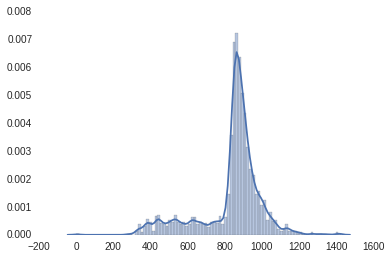

In [5]:
a = ser_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

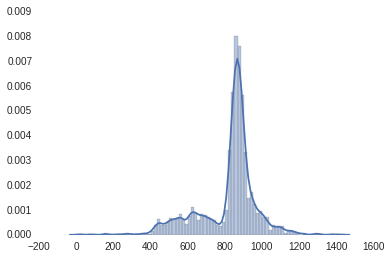

In [6]:
a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

In [10]:
def perform_RL(trial_order,rew_trial,alpha,exp):
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
                
        if trial_type is not None:
            rew = rew_trial[n]
            delta[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V) 
            index[trial_type].append(count)
            count += 1 

    return V, delta, index

In [32]:
##function for building dataframe of relevant data for each subject
def build_df(sub,num_runs,exp):
    
    alpha = .1 #just some arbitrary alpha to get things going
    order_dict = order_dict_exp[exp]
    predictors = {'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}
    
    for i in range(1,num_runs+1):
        ##perform RL for the experimental condition
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)

        #get rt data for this subject and run
        rts = rt_dict_exp[exp]
        rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]
        ##update predictors dict
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist
            predictors['V'].extend(V[key])
            predictors['PE'].extend(delta[key])
            predictors['cond'].extend([key]*len(V[key]))
            predictors['run'].extend(['run' + str(i)]*len(V[key]))
            predictors['trial_index'].extend(index[key])
            predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['run','trial_index']) #get predictors in proper order

    #Z score RT
    predictors['rt'] = predictors['rt'] - predictors['rt'].mean()
    predictors['rt'] = predictors['rt'] / predictors['rt'].std()
        
    #Z-score trial index for each row
    for i in range(1,num_runs+1):
        run = 'run' + str(i)
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
        predictors.loc[predictors['run']==run,'trial_index'].mean()
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
        predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [33]:
##returns loss for linear regression
def regress(params,predictors,num_runs,exp):
    
    alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
    beta = params[1:]
    
    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist
            predictors.loc[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key),'V'] = V[key]
            predictors.loc[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key),'PE'] = delta[key]

            
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V+run",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    return loss


In [56]:
params = (0,0,0,0,0,0) #initialize parameters to 0
#res = minimize(regress,params,method='BFGS', options={'disp': True})

In [59]:
##loop through all subjects
def run_subjects(sub_id):
    exp = 'ser'
    #get predictors dataframe
    num_runs = len(np.unique(ser_rts[ser_rts['sub']==sub_id]['run']))
    predictors = build_df(sub_id,num_runs,exp)

    #initialize
    params = (0,0,0,0,0,0) #initialize parameters to 0

    #minimize
#     res = minimize(regress,params,args=(predictors,num_runs,exp),method='Nelder-Mead', options={'disp': True})
    
    minimizer_kwargs = {"method": "BFGS",'args':(predictors,num_runs,exp)}
    res = basinhopping(regress, params, minimizer_kwargs=minimizer_kwargs,niter=50)

    return res

In [60]:
pool = multiprocessing.Pool(processes=30)
output = pool.map(run_subjects,subjects)

0.575596117804
-1.26530123314
0.891315890696
(-6.5053689026617691, 1.9113774817830713e-06)


(array([ 3.,  2.,  3.,  1.,  1.,  4.,  1.,  2.,  0.,  5.]),
 array([ 0.11303727,  0.20173353,  0.2904298 ,  0.37912606,  0.46782233,
         0.55651859,  0.64521486,  0.73391112,  0.82260739,  0.91130365,
         0.99999992]),
 <a list of 10 Patch objects>)

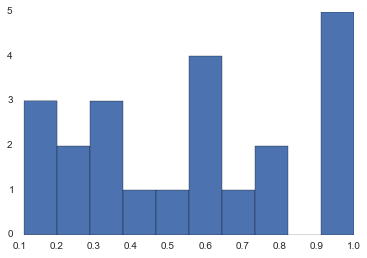

In [421]:
params = []
for n,o in enumerate(output):
    if o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

V_beta = [b for b in params[:,5] if b>-200]
alpha = map(lambda x: scipy.stats.logistic.cdf(x),params[:,0])
alpha = [a for n,a in enumerate(alpha) if params[:,5][n] > -200]

print np.mean(alpha)
print np.mean(V_beta)
print np.std(V_beta)
# plt.hist(V_beta)
print scipy.stats.ttest_1samp(V_beta,0)

plt.hist(alpha)

0.57559690482
-1.26529992809
0.891312027231
(-6.5053903909585422, 1.9112870254882023e-06)


(array([ 3.,  2.,  3.,  1.,  1.,  4.,  1.,  2.,  0.,  5.]),
 array([ 0.11303798,  0.20173418,  0.29043037,  0.37912657,  0.46782277,
         0.55651897,  0.64521517,  0.73391137,  0.82260757,  0.91130377,
         0.99999996]),
 <a list of 10 Patch objects>)

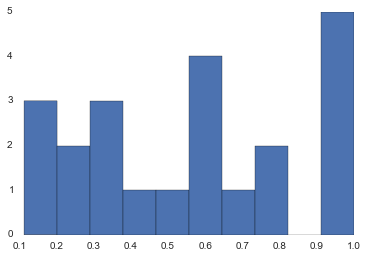

In [65]:
params = []
for n,o in enumerate(output):
    if True:#o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

V_beta = [b for b in params[:,5] if b>-200]
alpha = map(lambda x: scipy.stats.logistic.cdf(x),params[:,0])
alpha = [a for n,a in enumerate(alpha) if params[:,5][n] > -200]

print np.mean(alpha)
print np.mean(V_beta)
print np.std(V_beta)
print scipy.stats.ttest_1samp(V_beta,0)

plt.hist(alpha)


In [42]:
#double check that linear regression code works (given a fixed alpha)
clf = linear_model.LinearRegression(fit_intercept=False)
# clf.fit(X, y)
# clf.coef_

Now try to fit all subjects' data simultaneously

In [10]:
##function for building dataframe of relevant data for each subject
def build_df_all(num_runs, exp):
    order_dict = order_dict_exp[exp]
    alpha = .1
    predictors = {'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):

        ##perform RL for the experimental condition
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

        for sub in subjects:
            
            #get rt data for this subject and run
            rts = rt_dict_exp[exp]
            rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

            ##update predictors dict
            for key in V.keys():
                predictors['V'].extend(V[key])
                predictors['PE'].extend(delta[key])
                predictors['cond'].extend([key]*len(V[key]))
                predictors['subject'].extend([sub]*len(V[key]))
                predictors['run'].extend(['run' + str(i)]*len(V[key]))
                predictors['trial_index'].extend(index[key])
                predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['subject','run','trial_index']) #get predictors in proper order

    #Z score RT for each subject
    for sub in subjects:
        predictors.loc[predictors['subject']==sub,'rt'] =  predictors.loc[predictors['subject']==sub,'rt'] - \
        predictors.loc[predictors['subject']==sub,'rt'].mean()  
        predictors.loc[predictors['subject']==sub,'rt'] =  predictors.loc[predictors['subject']==sub,'rt'] / \
        predictors.loc[predictors['subject']==sub,'rt'].std() 
        
    #Z-score trial index for each row
    for i in range(1,num_runs+1):
        run = 'run' + str(i)
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
        predictors.loc[predictors['run']==run,'trial_index'].mean()
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
        predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [11]:
##function for building dataframe of relevant data for each subject
def build_df_all_bothexp(num_runs, exp):
    alpha = .1
    exp_list = ['ser','sim']
    predictors = {'exp':[],'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):
        for exp in exp_list:
            order_dict = order_dict_exp[exp]
            ##perform RL for the experimental condition
            event_order = exp_order[exp_order['exp']==exp]
            rew = np.array(event_order[event_order['run']==i]['rew'])
            tt = np.array(event_order[event_order['run']==i]['trial_order'])
            V, delta, index = perform_RL(tt,rew,alpha,exp)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

            for sub in subjects:

                #get rt data for this subject and run
                rts = rt_dict_exp[exp]
                rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

                ##update predictors dict
                for key in V.keys():
                    predictors['V'].extend(V[key])
                    predictors['PE'].extend(delta[key])
                    predictors['cond'].extend([key]*len(V[key]))
                    predictors['exp'].extend([exp]*len(V[key]))
                    predictors['subject'].extend([sub]*len(V[key]))
                    predictors['run'].extend(['run' + str(i)]*len(V[key]))
                    predictors['trial_index'].extend(index[key])
                    predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['subject','run','trial_index']) #get predictors in proper order

    #Z score RT for each subject
    for sub in subjects:
        for exp in exp:
            predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'] =  predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'] - \
            predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'].mean()  
            predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'] =  predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'] / \
            predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp),'rt'].std() 
        
    #Z-score trial index for each row
    for i in range(1,num_runs+1):
        run = 'run' + str(i)
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
        predictors.loc[predictors['run']==run,'trial_index'].mean()
        predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
        predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [14]:
##returns loss for linear regression
def regress_all(params,predictors,num_runs,exp):
    exp_list = ['ser','sim']

    alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
    beta = params[1:]

    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        for exp in exp_list:
            event_order = exp_order[exp_order['exp']==exp]
            rew = np.array(event_order[event_order['run']==i]['rew'])
            tt = np.array(event_order[event_order['run']==i]['trial_order'])
            V, delta, index = perform_RL(tt,rew,alpha,exp)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist 
                predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key)  & (predictors['exp'] == exp), 'V'] = V[key]*len(subjects)
                predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key) & (predictors['exp'] == exp), 'PE'] = delta[key]*len(subjects)
    
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V+run",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    return loss
# regress_all(params,predictors,num_runs)

In [17]:
exp = 'ser'
params = [0]
params.extend(np.zeros(5))
num_runs  = 3
predictors = build_df_all_bothexp(num_runs,exp)
print predictors
loss = regress_all(params,predictors,num_runs,exp)
# bounds = [(0,1)]
# for i in range(0,5):
#     bounds.append((None,None))

#minimize
res = minimize(regress_all,params,args=(predictors,num_runs,exp),method='BFGS', options={'disp': True})
# minimizer_kwargs = {"method": "L-BFGS-B",'bounds':bounds,'args':(predictors,num_runs,exp)}
# ret = basinhopping(regress_all, params, minimizer_kwargs=minimizer_kwargs,niter=50)


            PE         V     cond  exp       rt   run subject  trial_index
10    0.000000  0.000000   b_plus  ser      NaN  run1  fd_104    -1.688900
1140  0.000000  0.000000  b_minus  sim      NaN  run1  fd_104    -1.688900
0     1.000000  0.000000   c_plus  ser      NaN  run1  fd_104    -1.602290
1141  0.000000  0.000000  b_minus  sim      NaN  run1  fd_104    -1.602290
1     0.900000  0.100000   c_plus  ser  770.000  run1  fd_104    -1.515680
1120  1.000000  0.000000   c_plus  sim      NaN  run1  fd_104    -1.515680
30    1.000000  0.000000  c_minus  ser  751.000  run1  fd_104    -1.429070
1142  0.000000  0.000000  b_minus  sim      NaN  run1  fd_104    -1.429070
11    1.000000  0.000000   b_plus  ser      NaN  run1  fd_104    -1.342459
1121  0.900000  0.100000   c_plus  sim  506.000  run1  fd_104    -1.342459
20    0.000000  0.000000  b_minus  ser      NaN  run1  fd_104    -1.255849
1122 -0.190000  0.190000   c_plus  sim      NaN  run1  fd_104    -1.255849
12    0.900000  0.100000 

Bootstrap to get the null distribution

In [35]:
def minimize_bs(in_tuple):
    predictors,num_runs,exp = in_tuple
    
    #perform minimization
    res = minimize(regress_all_fixed_beta,params,args=(predictors,num_runs,exp),method='BFGS', options={'disp': True})

    return res

In [15]:
##perform bootstrapping to generate a null distribution of beta
n_samples = 1000
exp = 'ser'
params = [0]
params.extend(np.zeros(5))
num_runs  = 3
predictors = build_df_all(num_runs,exp)

pred_list = []
for i in range(n_samples):
             
    #shuffle RTs
    rts = predictors[predictors['rt'].notnull()]['rt'].values
    random.shuffle(rts)
    predictors.loc[predictors['rt'].notnull(),'rt'] = rts
    
    pred_list.append((predictors.copy(),num_runs,exp))

In [34]:
# pool = multiprocessing.Pool(processes=50)
# output = pool.map(minimize_bs,pred_list)

0.088


(array([   3.,    0.,    6.,   22.,   49.,  852.,   36.,   15.,   11.,    6.]),
 array([-59.96965821, -48.6134081 , -37.25715798, -25.90090786,
        -14.54465774,  -3.18840762,   8.1678425 ,  19.52409262,
         30.88034274,  42.23659286,  53.59284298]),
 <a list of 10 Patch objects>)

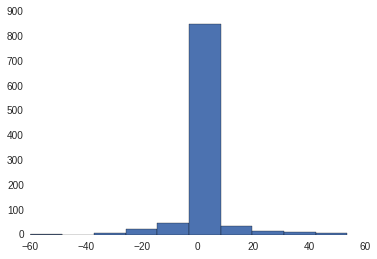

In [24]:
params = []
for n,o in enumerate(output):
    if True:#o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

v_beta = -1.16

a = params[:,5] > 1.16
print float(np.sum(a))/len(params[:,5])
plt.hist(params[:,5])

In [314]:
print res
print scipy.stats.logistic.cdf(res.x[0])

   status: 0
  success: True
     njev: 19
     nfev: 152
 hess_inv: array([[  5.50651905e+00,  -3.07922673e-01,   2.33267479e-02,
         -5.94927013e-02,  -4.75468318e-01,   2.08926805e+00],
       [ -3.07922673e-01,   1.42649614e-01,  -7.40082290e-02,
         -6.84640981e-02,   3.89242964e-02,  -2.47989508e-01],
       [  2.33267479e-02,  -7.40082290e-02,   1.40476483e-01,
          7.18888574e-02,  -6.67026668e-03,   1.40855404e-02],
       [ -5.94927013e-02,  -6.84640981e-02,   7.18888574e-02,
          1.43918324e-01,   2.52228032e-03,  -1.81637030e-02],
       [ -4.75468318e-01,   3.89242964e-02,  -6.67026668e-03,
          2.52228032e-03,   6.87146314e-02,  -2.08121203e-01],
       [  2.08926805e+00,  -2.47989508e-01,   1.40855404e-02,
         -1.81637030e-02,  -2.08121203e-01,   1.10509382e+00]])
      fun: 37.44672203113975
        x: array([-0.47898567,  0.3620377 ,  0.12028519,  0.15692983,  0.00447625,
       -1.11605283])
  message: 'Optimization terminated successfull

In [171]:
ret

                  nfev: 7196
 minimization_failures: 0
                   fun: 37.446722031145107
                     x: array([ 0.38249334,  0.36203726,  0.12028474,  0.15693011,  0.00447598,
       -1.11605044])
               message: ['requested number of basinhopping iterations completed successfully']
                   nit: 50

In [208]:
res

  status: 0
 success: True
    nfev: 182
     fun: 37.710933119262073
       x: array([ 0.25209737,  0.16060626,  0.25796919,  0.38188396,  0.08537042,
       -1.05208584])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([  3.55271368e-06,   7.10542736e-07,  -2.84217094e-06,
        -2.13162821e-06,   5.68434189e-06,   0.00000000e+00])
     nit: 20

In [211]:
ret

                  nfev: 8344
 minimization_failures: 0
                   fun: 37.710933119262073
                     x: array([ 0.25209737,  0.16060626,  0.25796919,  0.38188396,  0.08537042,
       -1.05208584])
               message: ['requested number of basinhopping iterations completed successfully']
                   nit: 50

In [296]:
#update experiment file with PE regressor made from the best fitting alpha
best_alphas = {'ser':.38, 'sim':.25}
timing_info = pd.read_csv(data_dir + '/timing_info.csv', index_col =0)

for exp in best_alphas.keys():
    
    alpha = best_alphas[exp]
    
    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        
        for key in V.keys():
            deltas = delta[key]
            deltas = list(deltas - np.mean(deltas)) #mean center
            timing_info.ix[(timing_info['run'] == i) & (timing_info['condition'] == key) & \
                                 (timing_info['exp']==exp),'PE'] = deltas*len(subjects)
timing_info.to_csv(data_dir + '/timing_info.csv')

NameError: name 'timing' is not defined

Next try bootstrapping with the best fit beta values and examine the distribution of alpha

In [36]:
##returns loss for linear regression
def regress_all_fixed_beta(params,predictors,num_runs,exp):
    
    alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
    beta = [0.3620377 ,  0.12028519,  0.15692983,  0.00447625, -1.11605283]

    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        event_order = exp_order[exp_order['exp']==exp]
        rew = np.array(event_order[event_order['run']==i]['rew'])
        tt = np.array(event_order[event_order['run']==i]['trial_order'])
        V, delta, index = perform_RL(tt,rew,alpha,exp)
        for key in V.keys():
            V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist 
            predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key), 'V'] = V[key]*len(subjects)
            predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key), 'PE'] = delta[key]*len(subjects)
    
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V+run",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    return loss

In [37]:
##perform bootstrapping to generate a null distribution of beta
n_samples = 1000
exp = 'ser'
params = [0]
num_runs  = 3
predictors = build_df_all(num_runs,exp)

pred_list = []
for i in range(n_samples):
             
    #shuffle RTs
    rts = predictors[predictors['rt'].notnull()]['rt'].values
    random.shuffle(rts)
    predictors.loc[predictors['rt'].notnull(),'rt'] = rts
    
    pred_list.append((predictors.copy(),num_runs,exp))

In [39]:
# pool = multiprocessing.Pool(processes=75)
# output = pool.map(minimize_bs,pred_list)














         Current function value: 41.138186
         Current function value: 41.228973
         Current function value: 41.179744
         Current function value: 40.827919
         Current function value: 41.545869
         Current function value: 41.004219
         Current function value: 41.111988
         Current function value: 41.003044
         Current function value: 41.034885
         Current function value: 41.213170
         Current function value: 41.140069
         Current function value: 41.439245
         Current function value: 41.665918
         Current function value: 40.929579
         Current function value: 41.336090
         Current function value: 41.426448
         Current function value: 41.099742
         Current function value: 41.400225
         Current function value: 41.333620
         Current function value: 41.466764
         Current function value: 41.388293
         Current function value: 40.906868
         Current function value: 41.58649

         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 15
         Function evaluations: 18
         Function evaluations: 21
         Function evaluations: 18
         Function evaluations: 21
         Function evaluations: 18
         Function evaluations: 21
         Function evaluations: 21
         Function evaluations: 21
         Function evaluations: 15
         Function evaluations: 21
         Function evaluations: 15
         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 15
         Function evaluations: 18
         Function evaluations: 21
         Function evaluations: 21
         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 18
         Function evaluations: 15
         Function evaluations: 21
         Function evaluations: 15
         Function evaluations: 15
         Funct

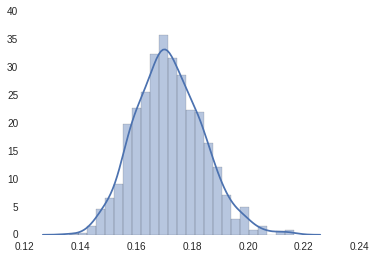






















         Current function value: 41.379235
         Current function value: 41.276005
         Current function value: 40.958069
         Current function value: 41.201908
         Current function value: 41.341333
         Current function value: 41.278534
         Current function value: 41.178081
         Current function value: 40.967749
         Current function value: 41.653554
         Current function value: 41.376193
         Current function value: 41.326117
         Current function value: 41.445540
         Current function value: 41.369476
         Current function value: 41.757635
         Current function value: 41.331518
         Current function value: 41.073413
         Current function value: 41.635714
         Current function value: 41.664936
         Current function value: 41.360558
         Current function value: 40.901542
         Current function value: 41.223570
         Current function value: 41.132344
         Current function value: 

In [42]:
params = []
for n,o in enumerate(output):
    if True:#o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

params = map(lambda x: scipy.stats.logistic.cdf(x),params)
sns.distplot(params);